In [1]:
from google.colab import files
uploaded = files.upload()

Saving NomorTangan.zip to NomorTangan.zip


In [2]:
import zipfile
import os
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

In [3]:
# Nama file zip
zip_path = 'NomorTangan.zip'

# Folder tujuan ekstraksi
extract_to = 'dataset'

# Ekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Lihat daftar file
for root, dirs, files in os.walk(extract_to):
    print(root, len(files))

dataset 0
dataset/NomorTangan 0
dataset/NomorTangan/1 500
dataset/NomorTangan/0 500
dataset/NomorTangan/2 500


In [4]:
# Set seed
tf.random.set_seed(42)
base_dir = 'dataset/NomorTangan'
split_dir = 'dataset/split_data'
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [5]:
# Split Data
for split in [train_dir, val_dir, test_dir]:
    os.makedirs(split, exist_ok=True)

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)

    split_counts = {
        'train': images[:train_count],
        'val': images[train_count:train_count + val_count],
        'test': images[train_count + val_count:]
    }

    for split_name, file_list in split_counts.items():
        split_class_dir = os.path.join(split_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for fname in file_list:
            shutil.copy2(os.path.join(class_path, fname), os.path.join(split_class_dir, fname))


In [6]:
# Data Generator
tf.random.set_seed(42)

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [7]:
# Model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # karena ada 3 kelas
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Callback untuk stop jika akurasi sudah tercapai
class StopAtAccuracy(Callback):
    def __init__(self, target_acc=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc >= self.target_acc and val_acc >= self.target_acc:
            print(f"\n🎯 Akurasi mencapai {self.target_acc*100}%, training dihentikan.")
            self.model.stop_training = True


In [9]:
# Training
stop_callback = StopAtAccuracy(target_acc=0.95)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[stop_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7027 - loss: 0.5950 - val_accuracy: 0.9956 - val_loss: 0.0204
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9968 - loss: 0.0281
🎯 Akurasi mencapai 95.0%, training dihentikan.
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9967 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 4.9629e-04


In [10]:
# Evaluasi akurasi pada test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'\n✅ Akurasi pada test set: {test_accuracy*100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 1.0000 - loss: 5.2592e-04

✅ Akurasi pada test set: 100.00%


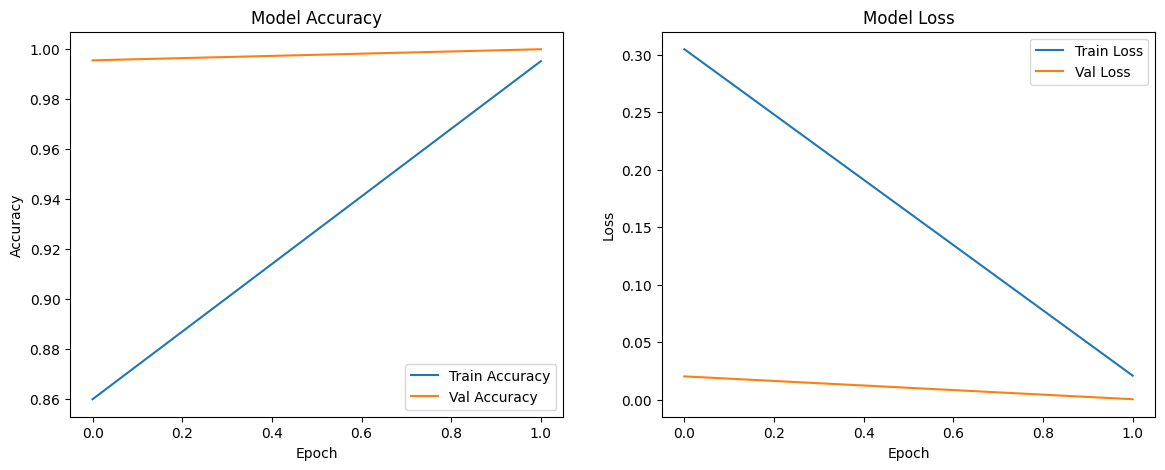

In [11]:
# Plot akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
tf.saved_model.save(model, 'saved_model/my_model')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model/my_model tfjs_model

2025-04-19 14:19:00.778760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745072340.849231    3120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745072340.864918    3120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-19 14:19:16.922986: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745072357.508682    3120 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
shutil.make_archive('my_model', 'zip', 'saved_model/my_model')

'/content/my_model.zip'

In [ ]:
import shutil
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')


'/content/tfjs_model.zip'

In [ ]:
!pip freeze > requirements.txt